In [38]:
import os
import re 
import shutil
import rasterio

import xarray as xr
import numpy as np
from weather_mv.loader_pipeline.sinks import open_dataset
from weather_mv.loader_pipeline.ee import get_ee_safe_name, make_attrs_ee_compatible

from apache_beam.io.filesystems import FileSystems
from apache_beam.io.gcp.gcsio import WRITE_CHUNK_SIZE
from rasterio import MemoryFile
from rasterio.plot import show

In [89]:
netcdf_multistep = "/home/aniket/infocusp/anthromet/weather-tools-aniket/weather_mv/test_data/test_data_20180101.nc"
grib_single_step = "/home/aniket/infocusp/anthromet/weather-tools-aniket/weather_mv/test_data/test_data_grib_single_timestep"

netcdf_ds = xr.open_dataset(netcdf_multistep)
grib_ds = xr.open_dataset(grib_single_step, engine='cfgrib')

uri = netcdf_multistep
ds = netcdf_ds

# ds = ds.isel(time=0)
# ds = ds.drop('time')


In [ ]:
ds

In [ ]:
new_ds = ds
for i in range(len(ds['time'])):
    da = ds.isel(time=i)
    # print(da)
    for var_name, var in da.data_vars.items():
        new_ds[f"{var_name}_{ds['time'][i]}"] = var
    # print("-------")
new_ds

In [ ]:
with open_dataset(uri) as ds:
    ds = ds.isel(time=0)
    attrs = ds.attrs
    data = list(ds.values())
    asset_name = get_ee_safe_name(uri)
    channel_names = [da.name for da in data]
    start_time, end_time, is_normalized = (attrs.get(key) for key in
                                            ('start_time', 'end_time', 'is_normalized'))
    dtype, crs, transform = (attrs.pop(key) for key in ['dtype', 'crs', 'transform'])
    attrs.update({'is_normalized': str(is_normalized)})  # EE properties does not support bool.
    # Make attrs EE ingestable.
    attrs = make_attrs_ee_compatible(attrs)

    # Process dataset here
    # Make a new dataset having data variables as cross product of all mentioned data variables

    with MemoryFile() as memfile:
        with memfile.open(driver='COG',
                            dtype=dtype,
                            width=data[0].data.shape[1],
                            height=data[0].data.shape[0],
                            count=len(data),
                            nodata=np.nan,
                            crs=crs,
                            transform=transform,
                            compress='lzw') as f:
            for i, da in enumerate(data):
                f.write(da, i+1)
                # Making the channel name EE-safe before adding it as a band name.
                f.set_band_description(i+1, get_ee_safe_name(channel_names[i]))
                f.update_tags(i+1, band_name=channel_names[i])
                f.update_tags(i+1, **da.attrs)
            # Write attributes as tags in tiff.
            f.update_tags(**attrs)
        file_name = f'{asset_name}.tiff'
        # Copy in-memory tiff to gcs.
        target_path = os.path.join("/home/aniket/infocusp/anthromet/weather-tools-aniket/weather_mv/test_data", file_name)
        with FileSystems().create(target_path) as dst:
            shutil.copyfileobj(memfile, dst, WRITE_CHUNK_SIZE)

Metadata for Band 1:
  band_name: d2m
  long_name: 2 metre dewpoint temperature
  units: K


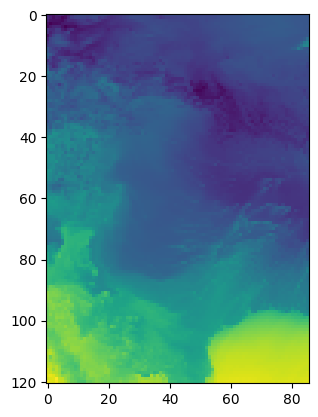

Metadata for Band 2:
  band_name: u10
  long_name: 10 metre U wind component
  units: m s**-1


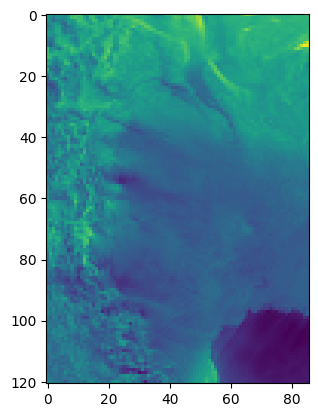

Metadata for Band 3:
  band_name: v10
  long_name: 10 metre V wind component
  units: m s**-1


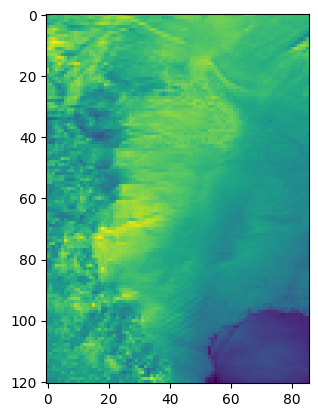

In [55]:
img = rasterio.open (target_path)
# Get the list of band indexes
num_bands = img.count

# Iterate over each band
for band_index in range(1, num_bands+1):
    # Get the metadata tags for the current band
    band_tags = img.tags(band_index)

    # Print band metadata
    print(f"Metadata for Band {band_index}:")
    for tag_name, tag_value in band_tags.items():
        print(f"  {tag_name}: {tag_value}")
    show(img.read(band_index)) 